As a media company, helping local small and medium sized businessess through digital advertising is one of our main revenue streams. We do so by running advertising campaigns on behalf of our clients on platforms such as Google and Facebook. In this exercise the task is to predict if a client will stop running advertising campaigns(churn).

# Loading libraries

In [1]:
#Data processing libraries
import pandas as pd
import numpy as np 
import itertools
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

#Modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score,recall_score,cohen_kappa_score
import statsmodels.api as sm
from yellowbrick.classifier import DiscriminationThreshold
from imblearn.over_sampling import SMOTE

#Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

# Data Manipulation

In [2]:
#loading the data
adv_churn = pd.read_csv('assets/data.csv', 
                        names=['CPL_wrt_BC','client_state','duration','num_prods',
                               'calls','CPL_wrt_self','churn','avg_budget','BC','clicks'])

#let's have a look at the data
adv_churn.head()

,CPL_wrt_BC,client_state,duration,num_prods,calls,CPL_wrt_self,churn,avg_budget,BC,clicks
0,0.000000,AZ,73,6,2,NaN,1,10082.152554,Beauty & Personal Care,107
1,-0.623618,CA,1,1,3,0.000000,0,133.928571,"Shopping, Collectibles & Gifts (General)",79
2,0.007905,NY,102,2,8,-0.292008,0,3935.017462,"Personal Services (Weddings, Cleaners, etc.)",90
3,-0.104900,MN,6,1,5,0.587206,0,461.538462,Travel,112
4,-0.013057,NJ,34,1,6,-0.955335,1,314.705882,Health & Fitness,95


In [3]:
#Interesting, so we have two categorical values and rest are numerical. 
#Let's try to get more insight on the data-set.

print ("Number of Rows : " ,adv_churn.shape[0])
print ("\nColumns  : " ,adv_churn.shape[1])
print ("\nFeatures : " ,adv_churn.columns.tolist())
print ("\nMissing values : ", adv_churn.isnull().sum().values.sum())
print ("\nUnique values :\n",adv_churn.nunique())

Number of Rows :  10000

Columns  :  10

Features :  ['CPL_wrt_BC', 'client_state', 'duration', 'num_prods', 'calls', 'CPL_wrt_self', 'churn', 'avg_budget', 'BC', 'clicks']

Missing values :  1092

Unique values :
 CPL_wrt_BC      9034
client_state      51
duration         116
num_prods         12
calls             10
CPL_wrt_self    7682
churn              2
avg_budget      9395
BC                31
clicks           203
dtype: int64


In [4]:
#So we know that the data-set has 1092 missing values and all of them are on CPL_wrt_self. 
#Next I want to look into the numerical features distribution.
categorical_features = [
    'client_state',
    'BC'
]

numerical_features = ['CPL_wrt_BC', 'duration', 'num_prods', 'calls', 'CPL_wrt_self', 'avg_budget', 'clicks']
target = 'churn'

adv_churn[numerical_features].describe()

,CPL_wrt_BC,duration,num_prods,calls,CPL_wrt_self,avg_budget,clicks
count,10000.000000,10000.000000,10000.000000,10000.000000,8908.000000,10000.000000,10000.000000
mean,-0.068958,27.669200,1.327200,4.526100,0.602664,1512.601132,99.214900
std,0.491693,25.500847,0.816582,2.859185,11.135854,3473.160720,31.701757
min,-0.994590,1.000000,0.000000,0.000000,-1.000000,9.090909,13.000000
25%,-0.103273,6.000000,1.000000,2.000000,-0.255226,476.056955,76.000000
50%,-0.088810,19.000000,1.000000,5.000000,0.000000,907.839383,96.000000
75%,-0.048530,42.000000,1.000000,7.000000,0.311280,1666.499256,119.000000
max,19.088412,118.000000,11.000000,9.000000,841.288094,148555.594376,253.000000


# Exploratory data analysis

In [5]:
#Let's plot the churn on a pie chart

#labels
lab = adv_churn["churn"].value_counts().keys().tolist()
#values
val = adv_churn["churn"].value_counts().values.tolist()

trace = go.Pie(labels = lab ,
               values = val ,
               marker = dict(colors =  [ 'rgb(0,155,255)' ,'rgb(235,30,0)'],
                             line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5,
              )
layout = go.Layout(dict(title = "Customer attrition in data",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

data = [trace]
fig = go.Figure(data = data,layout = layout)
py.iplot(fig)

So 20% of the dataset is of churned customer's and 80% is non churned customers

In [6]:
#I also want to know the frequency distribution among categorical values.

states = pd.value_counts(adv_churn['client_state']).to_frame().reset_index()

data = [
    go.Bar(
        x=states['index'], # assign x as the dataframe column 'x'
        y=states['client_state'],
        marker =dict(color ='rgb(0,155,255)') ,
    )
]

layout = go.Layout(dict(title = "Client State distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [7]:
#Similarly for BC
bc = pd.value_counts(adv_churn['BC']).to_frame().reset_index()

data = [
    go.Bar(
        x=bc['index'], # assign x as the dataframe column 'x'
        y=bc['BC'],
        marker =dict(color ='rgb(0,155,255)') ,
    )
]

layout = go.Layout(dict(title = "BC distribution",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

There are many low frequenecy categories under both client_state and BC, which can be combined together. 

In [8]:
#Plotting Correlation between features

correlation = adv_churn.corr()
matrix_cols = correlation.columns.tolist()
corr_array  = np.array(correlation)
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Correlation Matrix",
                         plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        height = 720,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                       )
                  )

data = [trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

In [9]:
#Combining low frequency categories under BC and client_state.
adv_churn = adv_churn.apply(lambda x: x.mask(x.map(x.value_counts()) < 200, 'other') if x.name in ['BC', 'client_state'] else x)
adv_churn.head()

,CPL_wrt_BC,client_state,duration,num_prods,calls,CPL_wrt_self,churn,avg_budget,BC,clicks
0,0.000000,AZ,73,6,2,NaN,1,10082.152554,other,107
1,-0.623618,CA,1,1,3,0.000000,0,133.928571,"Shopping, Collectibles & Gifts (General)",79
2,0.007905,NY,102,2,8,-0.292008,0,3935.017462,"Personal Services (Weddings, Cleaners, etc.)",90
3,-0.104900,other,6,1,5,0.587206,0,461.538462,Travel,112
4,-0.013057,NJ,34,1,6,-0.955335,1,314.705882,Health & Fitness,95


In [10]:
#Keeping a separate churn and non churn customers
churn     = adv_churn[adv_churn["churn"] == 1]
not_churn = adv_churn[adv_churn["churn"] == 0]

In [11]:
#function for ploting pie chart for customer churn
def plot_pie(column) :
    
    trace1 = go.Pie(values  = churn[column].value_counts().values.tolist(),
                    labels  = churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "Churn Customers",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    hole    = .6
                   )
    trace2 = go.Pie(values  = not_churn[column].value_counts().values.tolist(),
                    labels  = not_churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    domain  = dict(x = [.52,1]),
                    hole    = .6,
                    name    = "Non churn customers" 
                   )


    layout = go.Layout(dict(title = column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .15, y = .5),
                                           dict(text = "Non churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .88,y = .5
                                               )
                                          ]
                           )
                      )
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    py.iplot(fig)


#function for ploting histogram for customer churn
def histogram(column) :
    trace1 = go.Histogram(x  = churn[column],
                          histnorm= "percent",
                          name = "Churn Customers",
                          marker = dict(line = dict(width = .5,
                                                    color = "black"
                                                    ),
                                        color = "rgb(0,155,255)"
                                        ),
                         opacity = .9 
                         ) 
    
    trace2 = go.Histogram(x  = not_churn[column],
                          histnorm = "percent",
                          name = "Non churn customers",
                          marker = dict(line = dict(width = .5,
                                              color = "black"
                                             ),
                                        color = "rgb(235,30,0)"
                                 ),
                          opacity = .9
                         )
    
    data = [trace1,trace2]
    layout = go.Layout(dict(title = column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = column,
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "percent",
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                           )
                      )
    fig  = go.Figure(data=data,layout=layout)
    py.iplot(fig)

In [12]:
plot_pie('num_prods')

In [13]:
histogram('client_state')

The percentage of churned customers is more in smaller states (marked as others) and Florida. In comparison states like CA and TX has less percentage of churned customers in comparison. 

In [14]:
histogram('BC')

Shopping, collectibles and gifts customers seems to be more happier in comparison to Automotive – Sale businesses. 

# Data preparation  for modeling

In [15]:
#Dummy variable for categories BC and client_state
adv_churn_for_modeling = pd.get_dummies(adv_churn, prefix='BC_', columns=['BC'])
adv_churn_for_modeling = pd.get_dummies(adv_churn_for_modeling, prefix='ClientState_', columns=['client_state'])

#Defining target column
target_col = ["churn"]

#Binary columns with just 2 values
binary_cols   = adv_churn_for_modeling.nunique()[adv_churn_for_modeling.nunique() == 2].keys().tolist()

#Label encoding Binary columns
le = LabelEncoder()
for i in binary_cols :
    adv_churn_for_modeling[i] = le.fit_transform(adv_churn_for_modeling[i])

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(adv_churn_for_modeling[numerical_features])
scaled = pd.DataFrame(scaled, columns=numerical_features)

#dropping original values merging scaled values for numerical columns
adv_churn_org = adv_churn_for_modeling.copy()
adv_churn_for_modeling = adv_churn_for_modeling.drop(columns = numerical_features, axis = 1)
adv_churn_for_modeling = pd.merge(adv_churn_for_modeling, scaled, left_index=True, right_index=True, how='left')

#Dropping NAN values
adv_churn_for_modeling = adv_churn_for_modeling.dropna()
adv_churn_for_modeling.head()

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



,churn,BC__Animals & Pets,BC__Attorneys & Legal Services,BC__Automotive -- For Sale,"BC__Automotive -- Repair, Service & Parts",BC__Business Services,BC__Dentists & Dental Services,BC__Education & Instruction,BC__Furniture,BC__Health & Fitness,...,ClientState__VA,ClientState__WA,ClientState__other,CPL_wrt_BC,duration,num_prods,calls,CPL_wrt_self,avg_budget,clicks
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,-1.128117,-1.045869,-0.400714,-0.533780,-0.054122,-0.396970,-0.637691
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.156330,2.914982,0.823963,1.215058,-0.080346,0.697502,-0.290689
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,-0.073103,-0.849787,-0.400714,0.165755,-0.001388,-0.302639,0.403313
4,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0.113696,0.248271,-0.400714,0.515522,-0.139916,-0.344918,-0.132961
5,0,0,0,0,0,0,0,0,0,0,...,0,1,0,-0.062930,1.973790,-0.400714,-0.883548,-0.076224,0.070955,-0.227598


In [16]:
#plotting correlation after dummy variable creation
correlation = adv_churn_for_modeling.corr()
matrix_cols = correlation.columns.tolist()
corr_array  = np.array(correlation)

trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Correlation Matrix for variables",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        height = 720,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )

data = [trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

# SMOTE Sampling

In [17]:
#SMOTE sampling for the dataset

cols    = [i for i in adv_churn_for_modeling.columns if i not in target_col]
X = adv_churn_for_modeling[cols]
Y = adv_churn_for_modeling[target_col]

print('Before OverSampling, the shape of X: {}'.format(X.shape))
print('Before OverSampling, the shape of Y: {}'.format(Y.shape))
print(pd.value_counts(Y['churn']).to_frame().reset_index())

os = SMOTE(random_state = 0)
os_smote_X, os_smote_Y = os.fit_sample(X,Y)
os_smote_X = pd.DataFrame(data = os_smote_X,columns=cols)
os_smote_Y = pd.DataFrame(data = os_smote_Y,columns=target_col)

print('After OverSampling, the shape of train_X: {}'.format(os_smote_X.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(os_smote_Y.shape))
print(pd.value_counts(os_smote_Y['churn']).to_frame().reset_index())

#Split train and test data using smote sampling
smote_train_X,smote_test_X,smote_train_Y,smote_test_Y = train_test_split(os_smote_X, os_smote_Y,
                                                                         test_size = .25 ,
                                                                         random_state = 111)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Before OverSampling, the shape of X: (8908, 41)
Before OverSampling, the shape of Y: (8908, 1)
   index  churn
0      0   7161
1      1   1747
After OverSampling, the shape of train_X: (14322, 41)
After OverSampling, the shape of train_y: (14322, 1) 

   index  churn
0      1   7161
1      0   7161


# Modeling

In [18]:
#function to print and plot basic graphs for each modeling method.
def advertising_churn_prediction(algorithm,training_x,testing_x,
                             training_y,testing_y,cols,cf,threshold_plot) :
    
    #fit the mdoel
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    #checking if coefficients or features
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features" :
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
        
    column_df     = pd.DataFrame(cols)
    coef_sumry    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
    
    #ploting the confusion matrix
    trace1 = go.Heatmap(z = conf_matrix ,
                        x = ["Not churn","Churn"],
                        y = ["Not churn","Churn"],
                        showscale  = False,colorscale = "Picnic",
                        name = "matrix")
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    #plot coeffs
    trace4 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Picnic",
                                  line = dict(width = .6,color = "black")))
    
    #subplot for ROC curve
    fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Confusion Matrix',
                                            'Receiver operating characteristic',
                                            'Feature Importances'))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,1,2)
    fig.append_trace(trace4,2,1)
    
    fig['layout'].update(showlegend=False, title="Model performance" ,
                         autosize = False,height = 900,width = 800,
                         margin = dict(b = 195))
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis3"].update(dict(showgrid = True,tickfont = dict(size = 10),
                                        tickangle = 90))
    py.iplot(fig)

## Logistic Regression

In [19]:
#Logistic regression
logit  = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

advertising_churn_prediction(logit,os_smote_X,smote_test_X,os_smote_Y,smote_test_Y,
                         cols,"coefficients",threshold_plot = True)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.63      0.58      0.60      1824
           1       0.59      0.64      0.62      1757

   micro avg       0.61      0.61      0.61      3581
   macro avg       0.61      0.61      0.61      3581
weighted avg       0.61      0.61      0.61      3581

Accuracy   Score :  0.6082099972074839
Area under curve :  0.6088097484747725 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3           -      ]



/anaconda3/lib/python3.6/site-packages/plotly/basedatatypes.py:1212: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/anaconda3/lib/python3.6/site-packages/plotly/basedatatypes.py:1212: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/anaconda3/lib/python3.6/site-packages/plotly/basedatatypes.py:1212: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/anaconda3/lib/python3.6/site-packages/plotly/basedatatypes.py:1212: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.




## RandomForest Classifier

In [20]:
#RandomForest
rfc = RandomForestClassifier(n_estimators = 1000,
                             random_state = 123,
                             max_depth = 9,
                             criterion = "gini")

advertising_churn_prediction(rfc, os_smote_X,smote_test_X,os_smote_Y,smote_test_Y,
                         cols,"features",threshold_plot = True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.81      0.81      0.81      1824
           1       0.80      0.80      0.80      1757

   micro avg       0.81      0.81      0.81      3581
   macro avg       0.81      0.81      0.81      3581
weighted avg       0.81      0.81      0.81      3581

Accuracy   Score :  0.8078748952806478
Area under curve :  0.8077867103016505 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3           -      ]



/anaconda3/lib/python3.6/site-packages/plotly/basedatatypes.py:1212: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/anaconda3/lib/python3.6/site-packages/plotly/basedatatypes.py:1212: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/anaconda3/lib/python3.6/site-packages/plotly/basedatatypes.py:1212: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/anaconda3/lib/python3.6/site-packages/plotly/basedatatypes.py:1212: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.




## Decision Tree Classifier

In [21]:
#DecisionTree
decision_tree = DecisionTreeClassifier(max_depth = 9,
                                       random_state = 123,
                                       splitter  = "best",
                                       criterion = "gini",
                                      )

advertising_churn_prediction(decision_tree,os_smote_X,smote_test_X,os_smote_Y,smote_test_Y,
                         cols,"features",threshold_plot = True)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

 Classification report : 
               precision    recall  f1-score   support

           0       0.81      0.76      0.78      1824
           1       0.76      0.81      0.79      1757

   micro avg       0.78      0.78      0.78      3581
   macro avg       0.78      0.78      0.78      3581
weighted avg       0.78      0.78      0.78      3581

Accuracy   Score :  0.7835800055850322
Area under curve :  0.784094823712668 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3           -      ]



/anaconda3/lib/python3.6/site-packages/plotly/basedatatypes.py:1212: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/anaconda3/lib/python3.6/site-packages/plotly/basedatatypes.py:1212: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/anaconda3/lib/python3.6/site-packages/plotly/basedatatypes.py:1212: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/anaconda3/lib/python3.6/site-packages/plotly/basedatatypes.py:1212: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.




## LGBMClassifier

In [22]:
#Light Gradient Boosting - learning rate has to be low, low max_depth
lgbm_c = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                        learning_rate=0.05, max_depth=6, min_child_samples=20,
                        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
                        n_jobs=-1, num_leaves=500, objective='binary', random_state=None,
                        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                        subsample_for_bin=200000, subsample_freq=0)

cols = [i for i in adv_churn_for_modeling.columns if i not in target_col]
advertising_churn_prediction(lgbm_c,os_smote_X,smote_test_X,os_smote_Y,smote_test_Y,
                         cols,"features",threshold_plot = True)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.05, max_depth=6,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=500, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

 Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.89      0.88      1824
           1       0.89      0.86      0.88      1757

   micro avg       0.88      0.88      0.88      3581
   macro avg       0.88      0.88      0.88      3581
weighted avg       0.88      0.88      0.88      3581

Accuracy   Score :  0.8796425579447081
Area under curve :  0.8793547614055057 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3           -      ]



/anaconda3/lib/python3.6/site-packages/plotly/basedatatypes.py:1212: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/anaconda3/lib/python3.6/site-packages/plotly/basedatatypes.py:1212: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/anaconda3/lib/python3.6/site-packages/plotly/basedatatypes.py:1212: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/anaconda3/lib/python3.6/site-packages/plotly/basedatatypes.py:1212: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.




## XGBoost Classifier

In [23]:
#XGBoost - learning rate has to be low, low max_depth
xgc = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
                    max_depth = 6, min_child_weight=1, missing=None, n_estimators=100,
                    n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=True, subsample=1)


advertising_churn_prediction(xgc,os_smote_X,smote_test_X,os_smote_Y,smote_test_Y,
                         cols,"features",threshold_plot = True)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

 Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.89      0.88      1824
           1       0.89      0.86      0.87      1757

   micro avg       0.88      0.88      0.88      3581
   macro avg       0.88      0.88      0.88      3581
weighted avg       0.88      0.88      0.88      3581

Accuracy   Score :  0.8779670483105277
Area under curve :  0.8776577586895525 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3           -      ]



/anaconda3/lib/python3.6/site-packages/plotly/basedatatypes.py:1212: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/anaconda3/lib/python3.6/site-packages/plotly/basedatatypes.py:1212: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/anaconda3/lib/python3.6/site-packages/plotly/basedatatypes.py:1212: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/anaconda3/lib/python3.6/site-packages/plotly/basedatatypes.py:1212: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.




## Support Vector Classifier

In [24]:
#SVC with linear kernal
svc_lin  = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
               decision_function_shape='ovr', degree=3, gamma=1.0, kernel='linear',
               max_iter=-1, probability=True, random_state=None, shrinking=True,
               tol=0.001, verbose=False)

advertising_churn_prediction(svc_lin,os_smote_X,smote_test_X,os_smote_Y,smote_test_Y,
                         cols,"coefficients",threshold_plot = False)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.0, kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.64      0.54      0.58      1824
           1       0.59      0.68      0.63      1757

   micro avg       0.61      0.61      0.61      3581
   macro avg       0.61      0.61      0.61      3581
weighted avg       0.61      0.61      0.61      3581

Accuracy   Score :  0.6082099972074839
Area under curve :  0.6095310175338745 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3           -      ]



/anaconda3/lib/python3.6/site-packages/plotly/basedatatypes.py:1212: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/anaconda3/lib/python3.6/site-packages/plotly/basedatatypes.py:1212: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/anaconda3/lib/python3.6/site-packages/plotly/basedatatypes.py:1212: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/anaconda3/lib/python3.6/site-packages/plotly/basedatatypes.py:1212: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.




In [25]:
#function to generate model report
def model_report(model,training_x,testing_x,training_y,testing_y,name) :
    model.fit(training_x,training_y)
    predictions  = model.predict(testing_x)
    accuracy     = accuracy_score(testing_y,predictions)
    recallscore  = recall_score(testing_y,predictions)
    precision    = precision_score(testing_y,predictions)
    roc_auc      = roc_auc_score(testing_y,predictions)
    f1score      = f1_score(testing_y,predictions) 
    kappa_metric = cohen_kappa_score(testing_y,predictions)
    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recallscore],
                       "Precision"       : [precision],
                       "f1_score"        : [f1score],
                       "Area_under_curve": [roc_auc],
                       "Kappa_metric"    : [kappa_metric],
                      })
    return df

In [26]:
#Running each model again to generate metrics table
model1 = model_report(logit,os_smote_X,smote_test_X,os_smote_Y,smote_test_Y,
                      "Logistic Reg")
model2 = model_report(decision_tree,os_smote_X,smote_test_X,os_smote_Y,smote_test_Y,
                      "Decision Tree")
model3 = model_report(rfc,os_smote_X,smote_test_X,os_smote_Y,smote_test_Y,
                      "Random Forest")
model4 = model_report(lgbm_c,os_smote_X,smote_test_X,os_smote_Y,smote_test_Y,
                      "LGBM Classifier")
model5 = model_report(xgc,os_smote_X,smote_test_X,os_smote_Y,smote_test_Y,
                      "XGBoost Classifier")
model6 = model_report(svc_lin,os_smote_X,smote_test_X,os_smote_Y,smote_test_Y,
                      "SVM Classifier Linear")

model_performances = pd.concat([model1,model2,
                                model3,model4,
                                model5, model6],axis = 0).reset_index()

model_performances = model_performances.drop(columns = "index",axis =1)

table  = ff.create_table(np.round(model_performances,3))

py.iplot(table)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConv

In [27]:
#Metric performance graph for all the used machine learning models
def output_tracer(metric,color) :
    tracer = go.Bar(y = model_performances["Model"] ,
                    x = model_performances[metric],
                    orientation = "h",name = metric ,
                    marker = dict(line = dict(width =.7),
                                  color = color)
                   )
    return tracer

layout = go.Layout(dict(title = "Model performances",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "metric",
                                     zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(l = 250),
                        height = 780
                       )
                  )


trace1  = output_tracer("Accuracy_score","#009BFF")
trace2  = output_tracer('Recall_score',"#00A53C")
trace3  = output_tracer('Precision',"#EB1E00")
trace4  = output_tracer('f1_score',"#FA5F00")
trace5  = output_tracer('Kappa_metric',"#00C3C3")

data = [trace1,trace2,trace3,trace4,trace5]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

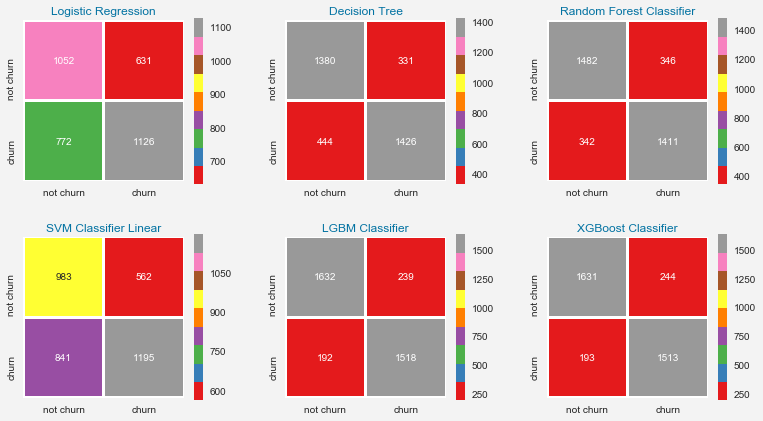

In [28]:
#Confusion matrix plot
lst    = [logit,decision_tree,rfc
          ,svc_lin,lgbm_c,xgc]

length = len(lst)

mods   = ['Logistic Regression',
          'Decision Tree','Random Forest Classifier',
          'SVM Classifier Linear', 'LGBM Classifier',
          'XGBoost Classifier']

fig = plt.figure(figsize=(13,15))
fig.set_facecolor("#F3F3F3")
for i,j,k in itertools.zip_longest(lst,range(length),mods) :
    plt.subplot(4,3,j+1)
    predictions = i.predict(smote_test_X)
    conf_matrix = confusion_matrix(predictions,smote_test_Y)
    sns.heatmap(conf_matrix,annot=True,fmt = "d",square = True,
                xticklabels=["not churn","churn"],
                yticklabels=["not churn","churn"],
                linewidths = 2,linecolor = "w",cmap = "Set1")
    plt.title(k,color = "b")
    plt.subplots_adjust(wspace = .3,hspace = .3)

LGBM and XGBoost Classifier performed the best. I used these algorithms as I knew they generally perform well on structured datasets. In-order to determine model performances I used metrics such as Accuracy, Recall, Precision, F1 score and Kappa metric. Logistic Regression ended up performing the worst. Special attention was given to recall and precision to make sure there isn’t any type 1 or type 2 errors. I also reduced the learning rates and depth on Tree classifiers to make sure that the trees don’t overfit. Hyperparameter tuning was done manually. I also tried non-linear spline model using SVM but it didn’t improve the overall performance.